In [1]:
import os
import sqlalchemy as db
import geopandas as gpd
import pandas as pd
import osmnx
from shapely.geometry import box, LineString, Point
from IPython.display import display, HTML
from shapely.ops import linemerge
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
POSTGRES_HOST="xxxx"
POSTGRES_PORT="xxxx"
POSTGRES_DB="xxxx"
POSTGRES_SCHEMA="xxxx"
POSTGRES_USER="xxxx"
POSTGRES_PASSWORD="xxx"

In [3]:
engine = db.create_engine('postgresql://{user}:{pw}@{host}/{db}'
                           .format(user=POSTGRES_USER,
                                   pw=POSTGRES_PASSWORD,
                                   host=POSTGRES_HOST,
                                   db=POSTGRES_DB,
                                   port=POSTGRES_PORT))

In [4]:
connection = engine.connect()

# Study area of Categena

min_lon =31.50
min_lat = 32.43
max_lon= 36
max_lat=  37.5
bbox = box(min_lon, min_lat, max_lon, max_lat)
bbox_wkt = bbox.wkt

In [26]:
query = "SELECT *,linestring AS geom FROM public.ways WHERE ST_Intersects(linestring, ST_GeomFromText('POLYGON ((0 37, 0 38, -1 38, -1 37, 0 37))', 4326)) AND (tags -> 'seamark:type'='separation_boundary' OR tags -> 'seamark:type'='separation_line' OR tags -> 'seamark:type'='separation_zone' OR tags -> 'seamark:type'='separation_lane')"
gdf_ways = gpd.read_postgis(query, engine)
#gdf_ways = gpd.read_postgis(query, engine)
gdf_ways['tstamp']=gdf_ways['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
print(gdf_ways.loc[4])
print(gdf_ways.loc[5])
print(gdf_ways.loc[6])
print(gdf_ways.loc[3])

id                                                      369835522
version                                                         1
user_id                                                   3213862
tstamp                                        2015-09-09 10:33:14
changeset_id                                             33904993
tags                          {'seamark:type': 'separation_line'}
nodes                        [3735830570, 3735830571, 3735830574]
linestring      0102000020E61000000300000055DFF945093AE1BFB18A...
bbox            0103000020E6100000010000000500000055DFF945093A...
geom            LINESTRING (-0.5383345 37.519995, -0.5000007 3...
Name: 4, dtype: object
id                                                      369835520
version                                                         1
user_id                                                   3213862
tstamp                                        2015-09-09 10:33:14
changeset_id                                         

In [13]:
gdf_ways.explore()

In [8]:
    filename = 'Case1/data/route_7.geojson'
    with open(filename) as file:
        rp_dict = json.load(file)

    point_list = rp_dict['features']
    count = len(point_list)
    lats_per_step = np.full(count, -99, dtype=float)
    lons_per_step = np.full(count, -99, dtype=float)

    color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
                  'lightred',
                  'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple',
                  'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black',
                  'lightgray']

    for ipoint in range(0, count):
        coord_pair = point_list[ipoint]['geometry']['coordinates']
        lats_per_step[ipoint] = coord_pair[1]
        lons_per_step[ipoint] = coord_pair[0]

    # Create LineString segments from X and Y columns
    segments = []
    for i in range(len(lons_per_step) - 1):
        segment = LineString([(lons_per_step[i], lats_per_step[i]),
                              (lons_per_step[i + 1], lats_per_step[i + 1])])
        segments.append(segment)

    # Add LineString segments to a new GeoDataFrame
    segments_gdf = gpd.GeoDataFrame(geometry=segments, crs="EPSG:4326")

    # Print the segments GeoDataFrame
    print(segments_gdf)


                                            geometry
0  LINESTRING (-0.62847 37.44632, -0.61483 37.48325)
1  LINESTRING (-0.61483 37.48325, -0.62205 37.53479)
2  LINESTRING (-0.62205 37.53479, -0.58996 37.59455)
3  LINESTRING (-0.58996 37.59455, -0.55628 37.63458)
4  LINESTRING (-0.55628 37.63458, -0.52820 37.66126)
5  LINESTRING (-0.52820 37.66126, -0.46804 37.68729)


In [10]:
seamark_gdf = gdf_ways 

seg geometry    LINESTRING (-0.6284656661578651 37.44632394159...
Name: 0, dtype: object
interesct point id                                                      369835521
version                                                         1
user_id                                                   3213862
tstamp                                        2015-09-09 10:33:14
changeset_id                                             33904993
tags                      {'seamark:type': 'separation_boundary'}
nodes                                    [3735830572, 3735830573]
linestring      0102000020E610000002000000B59146600769EDBF1C8B...
bbox            0103000020E61000000100000005000000B59146600769...
geometry            POINT (-0.6073349200175179 37.56219726164532)
Name: 0, dtype: object
interesct point id                                                      369835520
version                                                         1
user_id                                                   321386

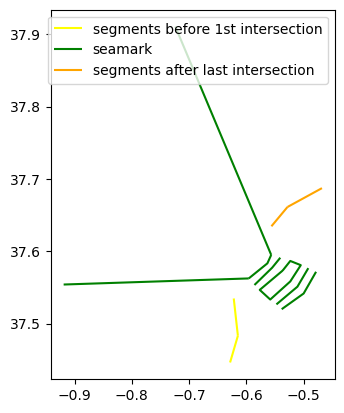

          x          y
1 -0.622049  37.534789
          x          y
4 -0.556276  37.634584


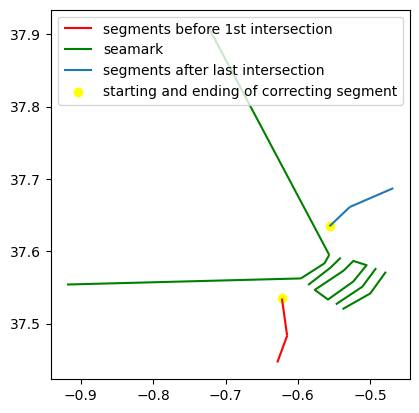

In [11]:
 # Perform spatial overlay to find intersections
intersection = gpd.overlay(segments_gdf, seamark_gdf, how='intersection',
                               keep_geom_type=False)


first_node = 0
indx_intersect = []
for index, seg in segments_gdf.iterrows():
    print('seg', seg)
    for j, inter_point in intersection.iterrows():
        print('interesct point', inter_point)
        buffered_point = inter_point.geometry.buffer(0.000001)
        val = seg.geometry.intersects(buffered_point)
        if (val):
            print('____________________________________________')
            indx_intersect.append(index)

print(indx_intersect)
segments_before_df = segments_gdf[0:indx_intersect[0]]

last_index = indx_intersect[len(indx_intersect) - 1]
last_index = last_index + 1
segments_after = segments_gdf[last_index:]

fig, ax = plt.subplots()
segments_before_df.plot(ax=ax, color='yellow',
                            label='segments before 1st intersection')
seamark_gdf.plot(ax=ax, color='green', label='seamark')
segments_after.plot(ax=ax, color = 'orange', label='segments after last intersection')
ax.legend()
plt.show()

first_node_line = segments_before_df.tail(1).geometry.get_coordinates()
point_start = first_node_line.tail(1)
print(point_start)
point_A = Point(point_start.x, point_start.y)

first_node_line = segments_after.head(1).geometry.get_coordinates()
point_end = first_node_line.head(1)
print(point_end)
point_B = Point(point_end.x, point_end.y)

points = [point_A, point_B]
p = gpd.GeoSeries(points)

fig, ax = plt.subplots()
segments_before_df.plot(ax=ax, color='red',
                            label='segments before 1st intersection')
seamark_gdf.plot(ax=ax, color='green', label='seamark')
segments_after.plot(ax=ax, label='segments after last intersection')
p.plot(ax=ax, color='yellow', label='starting and ending of correcting segment' )
ax.legend()
plt.show()

In [12]:
print(point_A)

POINT (-0.6220487764329903 37.534788816331655)


In [13]:
print(point_B)

POINT (-0.5562756567489942 37.63458351402787)


## Find the traffic separation lanes

In [14]:
query = "SELECT *,linestring AS geom FROM public.ways WHERE ST_Intersects(linestring, ST_GeomFromText('POLYGON ((0 37, 0 38, -1 38, -1 37, 0 37))', 4326)) AND ( tags -> 'seamark:type'='separation_lane')"
gdf_ways = gpd.read_postgis(query, engine)
gdf_ways['tstamp']=gdf_ways['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
gdf_ways

,id,version,user_id,tstamp,changeset_id,tags,nodes,linestring,bbox,geom
0,369843715,1,3213862,2015-09-09 11:32:50,33906358,{'seamark:type': 'separation_lane'},"[3735908103, 3735908102, 3735908100]",0102000020E610000003000000802260BE064EE1BF26E9...,0103000020E610000001000000050000003CF482F4B9BF...,"LINESTRING (-0.54077 37.59114, -0.55495 37.577..."
1,369843714,1,3213862,2015-09-09 11:32:50,33906358,{'seamark:type': 'separation_lane'},"[3735908098, 3735908099, 3735908101]",0102000020E6100000030000000F92AA926D85E1BF9BFD...,0103000020E610000001000000050000000F92AA926D85...,"LINESTRING (-0.54754 37.52663, -0.51086 37.551..."


In [15]:
gdf_ways.explore()


In [16]:
dist_list = []
for line in gdf_ways.geom:
    seamark_lane_segment = line
    x,y = seamark_lane_segment.xy
    seamark_start_point = Point(x[0], y[0])
    dist = point_A.distance(seamark_start_point)
    dist_list.append(dist)
    print(dist)

mind_dist_index = dist_list.index(min(dist_list))
print(mind_dist_index)

0.09889921827129518
0.07495616204803192
1


In [17]:
seperation_lane = gdf_ways.loc[mind_dist_index]
#seperation_lane_geom['geom'] =seperation_lane['geom']
print(type(seperation_lane))

<class 'pandas.core.series.Series'>


In [18]:
seperation_lane

id                                                      369843714
version                                                         1
user_id                                                   3213862
tstamp                                        2015-09-09 11:32:50
changeset_id                                             33906358
tags                          {'seamark:type': 'separation_lane'}
nodes                        [3735908098, 3735908099, 3735908101]
linestring      0102000020E6100000030000000F92AA926D85E1BF9BFD...
bbox            0103000020E610000001000000050000000F92AA926D85...
geom            LINESTRING (-0.5475376 37.5266334, -0.5108619 ...
Name: 1, dtype: object

In [20]:
seperation_lane_geom = seperation_lane.geom

In [21]:
print(seperation_lane_geom)
print(type(seperation_lane_geom))

LINESTRING (-0.5475376 37.5266334, -0.5108619 37.5510839, -0.4918737 37.5767049)
<class 'shapely.geometry.linestring.LineString'>


In [22]:
print(type(segments_before_df))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [23]:
segments_after

,geometry
4,"LINESTRING (-0.55628 37.63458, -0.52820 37.66126)"
5,"LINESTRING (-0.52820 37.66126, -0.46804 37.68729)"


## =============================================================================

In [196]:
segments_before_df

,geometry
0,"LINESTRING (-0.62847 37.44632, -0.61483 37.48325)"
1,"LINESTRING (-0.61483 37.48325, -0.62205 37.53479)"


Shapely LineString: LINESTRING (-0.6148297754911596 37.483250080379364, -0.6220487764329903 37.534788816331655)


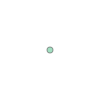

In [213]:
# Create ´connecting lines
last_line_start_seg = segments_before_df.tail(1)

geom =last_line_start_seg['geometry']
# Access one of the LineString geometries from the GeoSeries (for example, the first one)
line_gdf = last_line_start_seg.iloc[0]

# Convert the GeoDataFrame to a Shapely LineString
line_shapely = LineString(line_gdf.geometry.coords)

print("Shapely LineString:", line_shapely)
x, y = line_shapely.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)
last_point_rs = Point([df['x'].tail(1),df['y'].tail(1)])
last_point_rs

In [203]:
seperation_lane = gdf_ways.loc[mind_dist_index]
print(seperation_lane.geom)
print(type(seperation_lane.geom))

LINESTRING (-0.5475376 37.5266334, -0.5108619 37.5510839, -0.4918737 37.5767049)
<class 'shapely.geometry.linestring.LineString'>


In [182]:
x, y = seperation_lane.geom.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)

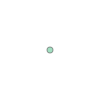

In [191]:
firts_point_sl = Point([df['x'].head(1),df['y'].head(1)])
firts_point_sl

In [216]:
segments_1 = LineString([last_point_rs,firts_point_sl ])
print(segments_1)

LINESTRING (-0.6220487764329903 37.534788816331655, -0.5475376 37.5266334)


#==============================

Shapely LineString: LINESTRING (-0.5562756567489942 37.63458351402787, -0.5282017641999914 37.6612574977633)


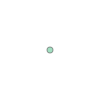

In [229]:
# Create ´connecting lines
first_line_end_seg = segments_after.head(1)

geom =first_line_end_seg['geometry']
# Access one of the LineString geometries from the GeoSeries (for example, the first one)
line_gdf = first_line_end_seg.iloc[0]

# Convert the GeoDataFrame to a Shapely LineString
line_shapely = LineString(line_gdf.geometry.coords)

print("Shapely LineString:", line_shapely)
x, y = line_shapely.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)
first_point_rs = Point([df['x'].head(1),df['y'].head(1)])
first_point_rs

LINESTRING (-0.5475376 37.5266334, -0.5108619 37.5510839, -0.4918737 37.5767049)
<class 'shapely.geometry.linestring.LineString'>


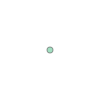

In [230]:
seperation_lane = gdf_ways.loc[mind_dist_index]
print(seperation_lane.geom)
print(type(seperation_lane.geom))
x, y = seperation_lane.geom.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)
last_point_sl = Point([df['x'].tail(1),df['y'].tail(1)])
last_point_sl

In [231]:
segments_2 = LineString([last_point_sl,first_point_rs ])
print(segments_2)

LINESTRING (-0.4918737 37.5767049, -0.5562756567489942 37.63458351402787)


## =================================================

In [232]:
# Create a new GeoDataFrame with the new LineString
first_line_Seg =  gpd.GeoDataFrame(geometry=[segments_1], crs=segments_before_df.crs)
seperation_lane = gpd.GeoDataFrame(geometry=[seperation_lane_geom], crs=segments_before_df.crs)
second_line_Seg =  gpd.GeoDataFrame(geometry=[segments_2], crs=segments_before_df.crs)

# Append the new GeoDataFrame to the existing one
#combined_gdf = segments_before_df.append(new_gdf, ignore_index=True)
combined_first_route_gdf = gpd.GeoDataFrame(pd.concat([segments_before_df, first_line_Seg], ignore_index=True), crs=segments_before_df.crs)
combined_gdf = gpd.GeoDataFrame(pd.concat([combined_first_route_gdf, seperation_lane], ignore_index=True), crs=segments_before_df.crs)
combined_last_route_seg = gpd.GeoDataFrame(pd.concat([combined_gdf, second_line_Seg], ignore_index=True), crs=segments_before_df.crs)
final_route = gpd.GeoDataFrame(pd.concat([combined_last_route_seg, segments_after], ignore_index=True), crs=segments_before_df.crs)
# Now combined_gdf contains the original LineStrings along with the new LineString
#print(combined_gdf)
# Now combined_gdf contains the original LineStrings along with the new LineString
print(final_route)

                                            geometry
0  LINESTRING (-0.62847 37.44632, -0.61483 37.48325)
1  LINESTRING (-0.61483 37.48325, -0.62205 37.53479)
2  LINESTRING (-0.62205 37.53479, -0.54754 37.52663)
3  LINESTRING (-0.54754 37.52663, -0.51086 37.551...
4  LINESTRING (-0.49187 37.57670, -0.55628 37.63458)
5  LINESTRING (-0.55628 37.63458, -0.52820 37.66126)
6  LINESTRING (-0.52820 37.66126, -0.46804 37.68729)


In [233]:
final_route.explore()

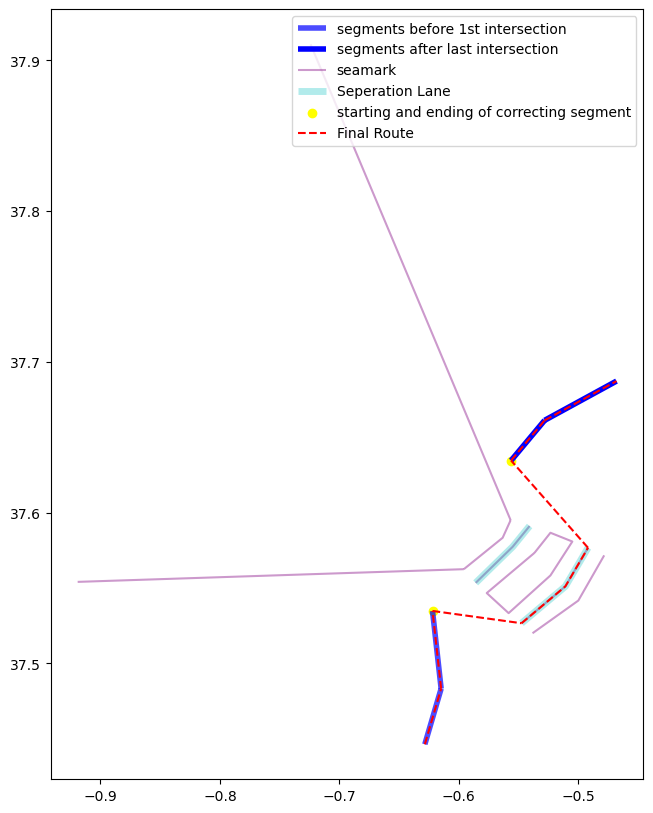

In [271]:
fig, ax = plt.subplots(figsize=(10,10))
segments_before_df.plot(ax=ax, color='blue',alpha=0.7,label='segments before 1st intersection', linewidth=4)
segments_after.plot(ax=ax, color='blue',label='segments after last intersection',  linewidth=4)
seamark_gdf.plot(ax=ax, color='purple', alpha=0.4, label='seamark')

gdf_ways.plot(ax=ax,  color='c',alpha=0.3, label='Seperation Lane',  linewidth=5)

p.plot(ax=ax, color='yellow', label='starting and ending of correcting segment' )
final_route.plot(ax=ax, color = 'red',linestyle='dashed', label='Final Route', linewidth=1.5)

ax.legend()
plt.show()
#plt.savefig( 'C:/Users/Maneesha/Documents/52N/TSS/Case1/routes_final.png')